# Simple Reinforcement Learning in Tensorflow: Part 1 - Multi-armed Bandit

Following along with this [medium blog](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149) post.

In [13]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import tensorflow as tf

Here, we are going to create a 4-armed bandit (mostly because 2 arm converges too fast). The pullBandit function generates a random number from a noral dist with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit that will give that positive reward.

(array([  2.00000000e+00,   1.00000000e+00,   7.00000000e+00,
          3.30000000e+01,   1.01000000e+02,   2.06000000e+02,
          4.30000000e+02,   8.01000000e+02,   1.13100000e+03,
          1.41300000e+03,   1.56000000e+03,   1.48300000e+03,
          1.17300000e+03,   7.74000000e+02,   4.70000000e+02,
          2.59000000e+02,   1.03000000e+02,   3.80000000e+01,
          1.10000000e+01,   4.00000000e+00]),
 array([-4.17596581, -3.78105151, -3.38613722, -2.99122292, -2.59630863,
        -2.20139433, -1.80648004, -1.41156575, -1.01665145, -0.62173716,
        -0.22682286,  0.16809143,  0.56300573,  0.95792002,  1.35283432,
         1.74774861,  2.14266291,  2.5375772 ,  2.9324915 ,  3.32740579,
         3.72232009]),
 <a list of 20 Patch objects>)

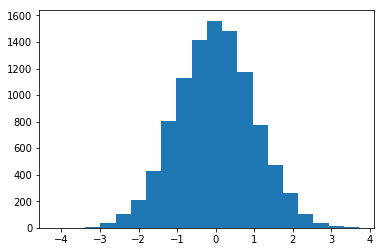

In [14]:
x = np.random.randn(10000)
plt.hist(x, bins=20)

In [15]:
# List our bandits. Currently 4 is set to most often 
# give a positive reward.
bandits = [0.2, 0, -0.2, -5]
num_bandits = len(bandits)
def pullBandit(bandit):
    result = np.random.randn(1)
    if result > bandit:
        return 1
    else:
        return -1    

## The Agent

The code below established our simple neural agent. It consists of a set of values for each of the bandits. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward. 

In [16]:
tf.reset_default_graph()

# Forward
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights, 0)

# Backward
reward_holder = tf.placeholder(shape=[1], dtype=tf.float32)
action_holder = tf.placeholder(shape=[1], dtype=tf.int32)
responsible_weight = tf.slice(weights, action_holder, [1])
loss = -(tf.log(responsible_weight) * reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

Let's train this bitch! with a $\epsilon$-greedy action decision, we will choose an action, get the reward and run our training with that.

In [22]:
total_episodes = 1000
total_reward = np.zeros(num_bandits)
e = 0.1

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        reward = pullBandit(bandits[action])
        
        #Update the network
        _, resp, ww = sess.run([update, responsible_weight, weights],
                              feed_dict={reward_holder:[reward],
                                         action_holder:[action]})
        
        total_reward[action] += reward
        if i % 50 == 0:
            print "Rewards for the bandits at " + str(i) + ": " + str(total_reward)
        i += 1
    print "The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising...."
    if np.argmax(ww) == np.argmax(-np.array(bandits)):
        print "...and it was right!"
    else:
        print "...and it was wrong!"

Rewards for the bandits at 0: [ 0.  0.  0.  1.]
Rewards for the bandits at 50: [ -1.  -1.   1.  46.]
Rewards for the bandits at 100: [ -1.   0.   3.  93.]
Rewards for the bandits at 150: [  -2.    0.    3.  142.]
Rewards for the bandits at 200: [  -3.    1.    2.  189.]
Rewards for the bandits at 250: [  -3.    3.    1.  236.]
Rewards for the bandits at 300: [  -2.    3.    1.  279.]
Rewards for the bandits at 350: [  -4.    4.    1.  324.]
Rewards for the bandits at 400: [  -3.    4.    1.  373.]
Rewards for the bandits at 450: [  -1.    4.    2.  416.]
Rewards for the bandits at 500: [  -1.    1.    2.  457.]
Rewards for the bandits at 550: [  -2.    0.    2.  505.]
Rewards for the bandits at 600: [  -2.    1.    3.  551.]
Rewards for the bandits at 650: [  -2.    1.    5.  599.]
Rewards for the bandits at 700: [  -2.    1.    4.  646.]
Rewards for the bandits at 750: [  -2.    2.    5.  692.]
Rewards for the bandits at 800: [  -3.    3.    4.  739.]
Rewards for the bandits at 850: [

# Contextual Bandits

In the prior exercise, we worked with multi-arm bandits, which really was an action->reward problem. In a full RL problem, we also have a state to deal with. From the state, the model chooses an action that it thinks would provide the best reward (or whatever it's policy is). Along with getting a reward, the action changes the change.  

We are gonna deal with something that's right in the middle. Where we have a state, we choose and action, and get a reward, BUT the action doesn't change the state.

Basically we are going to have multiple bandits, and each bandit is a different state. Since each bandit will have different reward probabilities for each arm, our agent will need to learn to condition its action on the state of the environment. 

In [59]:
class contextual_bandit():
    def __init__(self):
        self.state = 0
        self.bandits = np.array([[0.2,  0, -0.2,  -5],
                                 [0.1, -5,    1, 0.2], 
                                 [ -5,  5,    5,   5]])
        self.num_bandits = self.bandits.shape[0]
        self.num_actions = self.bandits.shape[1]
        
    def getBandit(self):
        self.state = np.random.randint(0, self.num_bandits)
        return self.state
    
    def pullArm(self, action):
        bandit = self.bandits[self.state, action]
        result = np.random.randn(1)
        if result > bandit:
            return 1
        else:
            return -1

## The Agent

We are gonna make a NN for our agent. The input will be the current state, and then we are gonna return an action. 

In [69]:
class agent():
    def __init__(self, lr, s_size, a_size):
        self.state_in = tf.placeholder(shape=[1], dtype=tf.int32)
        onehot = tf.one_hot(self.state_in, s_size)
        output = tf.layers.dense(onehot, a_size, 
                                 use_bias=True, 
                                 activation=tf.nn.sigmoid)
        self.output = tf.reshape(output, [-1])
        self.chosen_action = tf.argmax(self.output, 0)
        
        # Train shiz!
        self.reward_h = tf.placeholder(shape=[1], dtype=tf.float32)
        self.action_h = tf.placeholder(shape=[1], dtype=tf.int32)
        self.resp_wgt = tf.slice(self.output, self.action_h, [1])
        
        self.loss = -(tf.log(self.resp_wgt)*self.reward_h)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

Let's train this bitch!

In [70]:
tf.reset_default_graph()

c_Bandit = contextual_bandit()
myAgent = agent(lr=0.001, 
                s_size=c_Bandit.num_bandits,
                a_size=c_Bandit.num_actions)
weights = tf.trainable_variables()[0]

total_episodes = 10000
total_reward = np.zeros([c_Bandit.num_bandits, c_Bandit.num_actions])
e = 0.1

init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        s = c_Bandit.getBandit()
        if np.random.randn(1) < e:
            action = np.random.randint(c_Bandit.num_actions)
        else:
            action = sess.run(myAgent.chosen_action,
                              feed_dict={myAgent.state_in:[s]})
        reward = c_Bandit.pullArm(action)
        
        # Update the network
        feed_dict = {
            myAgent.reward_h: [reward],
            myAgent.action_h: [action],
            myAgent.state_in: [s]
        }
        _, ww = sess.run([myAgent.update, weights], feed_dict=feed_dict)
        
        total_reward[s, action] += reward
        if i % 500 == 0:
            print "Mean reward for each of the " + str(c_Bandit.num_bandits) + " bandits: " + str(np.mean(total_reward,axis=1))
        i+=1
for a in range(c_Bandit.num_bandits):
    print "The agent thinks action " + str(np.argmax(ww[a])+1) + " for bandit " + str(a+1) + " is the most promising...."
    if np.argmax(ww[a]) == np.argmin(c_Bandit.bandits[a]):
        print "...and it was right!"
    else:
        print "...and it was wrong!"

Mean reward for each of the 3 bandits: [-0.25  0.    0.  ]
Mean reward for each of the 3 bandits: [ -0.5   21.75 -31.  ]
Mean reward for each of the 3 bandits: [  0.5   42.75 -60.  ]
Mean reward for each of the 3 bandits: [  4.5   56.75 -84.5 ]
Mean reward for each of the 3 bandits: [  9.25  78.   -73.  ]
Mean reward for each of the 3 bandits: [ 13.75  95.5  -64.5 ]
Mean reward for each of the 3 bandits: [  14.25  114.5   -56.5 ]
Mean reward for each of the 3 bandits: [  18.5   127.5   -49.75]
Mean reward for each of the 3 bandits: [  29.25  144.5   -42.  ]
Mean reward for each of the 3 bandits: [  39.25  159.    -32.5 ]
Mean reward for each of the 3 bandits: [  45.5   174.    -19.25]
Mean reward for each of the 3 bandits: [  47.5   196.    -13.75]
Mean reward for each of the 3 bandits: [  50.5   217.     -6.25]
Mean reward for each of the 3 bandits: [  59.    242.5     5.25]
Mean reward for each of the 3 bandits: [  61.75  265.25   10.25]
Mean reward for each of the 3 bandits: [  66.7